In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F
from scipy.linalg import sqrtm

In [3]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=1287fb8513340cc519e1c3c8ab898bebc6178bf68957f15070253f523c3aa7b1
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


MedNIST Dataset

In [4]:
from medmnist import ChestMNIST

100%|██████████| 82.8M/82.8M [00:13<00:00, 6.09MB/s]


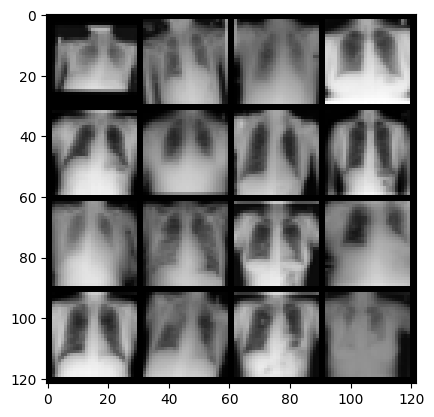

In [9]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ChestMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Check sample images
sample = next(iter(dataloader))[0][:16]  # Take first 16 images
grid_img = torchvision.utils.make_grid(sample, nrow=4, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28), 
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)  


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [8]:
latent_dim = 100
lr = 0.0002
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

loss_fn = nn.MSELoss()  


In [10]:
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        real_loss = loss_fn(discriminator(real_images), real_labels)
        fake_loss = loss_fn(discriminator(fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_loss_G = loss_fn(discriminator(fake_images), real_labels)  # Trick discriminator
        fake_loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {fake_loss_G.item():.4f}")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        torchvision.utils.save_image(fake_images[:16], f"ls-gan_epoch{epoch+1}.png", nrow=4, normalize=True)


Epoch [1/50] | D Loss: 0.0142 | G Loss: 1.3476
Epoch [2/50] | D Loss: 0.0699 | G Loss: 1.5124
Epoch [3/50] | D Loss: 0.0968 | G Loss: 1.0263
Epoch [4/50] | D Loss: 0.1160 | G Loss: 0.6298
Epoch [5/50] | D Loss: 0.0870 | G Loss: 1.0875
Epoch [6/50] | D Loss: 0.1360 | G Loss: 1.4945
Epoch [7/50] | D Loss: 0.2012 | G Loss: 0.6849
Epoch [8/50] | D Loss: 0.2499 | G Loss: 0.9580
Epoch [9/50] | D Loss: 0.1462 | G Loss: 1.2125
Epoch [10/50] | D Loss: 0.1454 | G Loss: 1.1798
Epoch [11/50] | D Loss: 0.1875 | G Loss: 0.8704
Epoch [12/50] | D Loss: 0.2289 | G Loss: 1.0704
Epoch [13/50] | D Loss: 0.1565 | G Loss: 0.6962
Epoch [14/50] | D Loss: 0.2145 | G Loss: 1.2152
Epoch [15/50] | D Loss: 0.1643 | G Loss: 0.9990
Epoch [16/50] | D Loss: 0.1202 | G Loss: 0.9571
Epoch [17/50] | D Loss: 0.1887 | G Loss: 0.8480
Epoch [18/50] | D Loss: 0.1989 | G Loss: 0.8290
Epoch [19/50] | D Loss: 0.2552 | G Loss: 0.6837
Epoch [20/50] | D Loss: 0.2838 | G Loss: 1.1325
Epoch [21/50] | D Loss: 0.1966 | G Loss: 1.2763
E

In [11]:
# Ensure output directories exist
os.makedirs("saved_models", exist_ok=True)
os.makedirs("generated_images", exist_ok=True)

In [12]:
# Save the trained models
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
print("Models saved successfully!")

Models saved successfully!


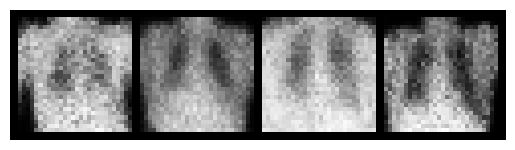

In [13]:
# Load and display generated images
img = plt.imread(f"ls-gan_epoch50.png")
plt.imshow(img)
plt.axis("off")
plt.show()


In [30]:
from torchvision.models import inception_v3, Inception_V3_Weights
# Load InceptionV3 Model
inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1).to(device)
inception_model.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 236MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [31]:
# Use the **test set** instead of the train set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = ChestMNIST(split='test', transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)


Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [32]:
# Get real test images
real_images, _ = next(iter(test_loader))
real_images = real_images[:1000]  # Limit to 1000 images for efficiency
real_images = real_images.to(device)


In [33]:

# Load pre-trained Generator
latent_dim = 100
generator = Generator(latent_dim).to(device)
generator.load_state_dict(torch.load("/kaggle/input/models/pytorch/default/1/generator.pth", map_location=device))
generator.eval()


<ipython-input-33-fc32911fd6ee>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/kaggle/input/models/pytorch/default/1/generator.pth",

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [34]:
# Generate fake images
num_samples = 1000  # Match real images count
z = torch.randn(num_samples, latent_dim).to(device)
fake_images = generator(z).detach().to(device)


In [35]:
# Function to compute Inception Score
def get_pred(x):
    with torch.no_grad():
        if x.shape[1] == 1:  # Convert grayscale to 3-channel
            x = x.repeat(1, 3, 1, 1)
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()

def inception_score(images, batch_size=32, splits=10):
    preds = np.zeros((len(images), 1000))
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        preds[i:i + batch_size] = get_pred(batch)
    
    split_scores = []
    for k in np.array_split(preds, splits):
        p_yx = np.mean(k, axis=0)
        p_yx = np.clip(p_yx, 1e-10, 1.0)
        k = np.clip(k, 1e-10, 1.0)
        kl_div = k * (np.log(k) - np.log(p_yx))
        split_scores.append(np.sum(kl_div, axis=1).mean())

    return np.exp(np.mean(split_scores))

# Function to compute FID Score
def calculate_fid(real_images, fake_images):
    real_images = real_images.view(real_images.size(0), -1).detach().cpu().numpy()
    fake_images = fake_images.view(fake_images.size(0), -1).detach().cpu().numpy()

    mu_real, sigma_real = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_images, axis=0), np.cov(fake_images, rowvar=False)

    fid_matrix = sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake)
    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(fid_matrix)

    return np.real(fid_score)

In [43]:
# Compute IS and FID using test dataset
is_score_real = inception_score(real_images)
fid_score = calculate_fid(real_images, fake_images)

print(f"Inception Score: {is_score_real:.4f}")
print(f"FID Score: {fid_score:.4f}")

Inception Score: 1.9261
FID Score: 16.5826


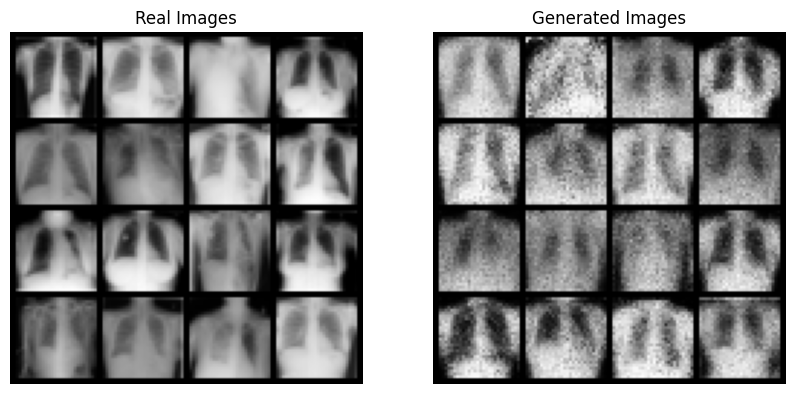

In [45]:
import torchvision.utils as vutils

# Function to show images
def show_images(real, fake, num_images=16):
    real = real[:num_images].cpu()
    fake = fake[:num_images].cpu()

    grid_real = vutils.make_grid(real, nrow=4, normalize=True)
    grid_fake = vutils.make_grid(fake, nrow=4, normalize=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(grid_real.permute(1, 2, 0))
    axes[0].set_title("Real Images")
    axes[0].axis("off")

    axes[1].imshow(grid_fake.permute(1, 2, 0))
    axes[1].set_title("Generated Images")
    axes[1].axis("off")

    plt.show()

# Show real vs generated images
show_images(real_images, fake_images)


In [ ]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard
writer = SummaryWriter("runs/lsgan_experiment")

# Function to log generated images
def log_generated_images(epoch, generator, latent_dim, num_images=16):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, device=device)
        fake_images = generator(z)

        # Convert grayscale to RGB if necessary
        if fake_images.shape[1] == 1:
            fake_images = fake_images.repeat(1, 3, 1, 1)

        # Create a grid of images
        grid = vutils.make_grid(fake_images, nrow=4, normalize=True)

        # Log images to TensorBoard
        writer.add_image("Generated Images", grid, epoch)

# Modify training loop to log loss and images
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Train Discriminator
        d_loss = train_discriminator(...)
        
        # Train Generator
        g_loss = train_generator(...)

        # Log losses
        writer.add_scalar("Loss/Discriminator", d_loss, epoch * len(dataloader) + i)
        writer.add_scalar("Loss/Generator", g_loss, epoch * len(dataloader) + i)

    # Log generated images at the end of each epoch
    log_generated_images(epoch, generator, latent_dim)

# Close TensorBoard writer
writer.close()
